In [55]:
import numpy as np
import gymnasium as gym
import minigrid
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import os
from gymnasium.wrappers import RecordVideo
from IPython.display import Video

np.random.seed(42)

In [65]:
def get_state(obs):
    """Convert observation to a hashable key."""
    return (obs["direction"], tuple(obs["image"].flatten()))

def greedy_action(q_lookup, state):
    """Select the action with the highest Q-value for a given state."""
    return int(np.argmax(q_lookup[state] if callable(q_lookup) is False else q_lookup(state)))

def run_eval(env, q_lookup, num_episodes=100, max_steps=100):
    """Evaluate a deterministic policy over multiple episodes."""
    rewards, steps, successes = [], [], []
    
    for _ in range(num_episodes):
        obs, _ = env.reset()
        state = get_state(obs)
        total_reward, step = 0, 0
        terminated = truncated = False

        while not (terminated or truncated) and step < max_steps:
            action = greedy_action(q_lookup, state)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            state = get_state(next_obs)
            total_reward += reward
            step += 1

        rewards.append(total_reward)
        steps.append(step)
        successes.append(int(reward > 0))

    return {
        "rewards": rewards,
        "steps": steps,
        "successes": successes
    }

def record_final_video(agent_q_func, filename="sarsa_final"):
    # Ensure output directory exists
    video_dir = "videos"
    os.makedirs(video_dir, exist_ok=True)

    # Wrap environment with video recorder
    env = RecordVideo(
        gym.make("MiniGrid-Dynamic-Obstacles-6x6-v0", render_mode="rgb_array"),
        video_folder=video_dir,
        name_prefix=filename,
        episode_trigger=lambda ep: True  # record the first episode
    )

    obs, _ = env.reset()
    state = get_state(obs)

    while True:
        action = greedy_action(agent_q_func, state)
        obs, _, terminated, truncated, _ = env.step(action)
        state = get_state(obs)
        
        if truncated:
            obs, _ = env.reset()
            state = get_state(obs)
        elif terminated:
            break

    env.close()
    return os.path.join(video_dir, f"{filename}-episode-0.mp4")


In [66]:
env = gym.make("MiniGrid-Dynamic-Obstacles-6x6-v0")

In [67]:
with open("sarsa_q.pkl", "rb") as f:
    sarsa_q = defaultdict(lambda: np.zeros(env.action_space.n), pickle.load(f))

with open("dq_q1.pkl", "rb") as f:
    dq_q1 = defaultdict(lambda: np.zeros(env.action_space.n), pickle.load(f))
with open("dq_q2.pkl", "rb") as f:
    dq_q2 = defaultdict(lambda: np.zeros(env.action_space.n), pickle.load(f))

In [70]:
sarsa_results = run_eval(env, sarsa_q)
video_path = record_final_video(sarsa_q, filename="sarsa_final")
Video(video_path)

In [71]:
dq_results = run_eval(env, lambda s: dq_q1[s] + dq_q2[s])
video_path = record_final_video(lambda s: dq_q1[s] + dq_q2[s], filename="dq_final")
Video(video_path)

SARSA – Success Rate: 1.00, Avg Reward: 0.79, Avg Steps: 33.03
Double Q-Learning – Success Rate: 1.00, Avg Reward: 0.81, Avg Steps: 29.62


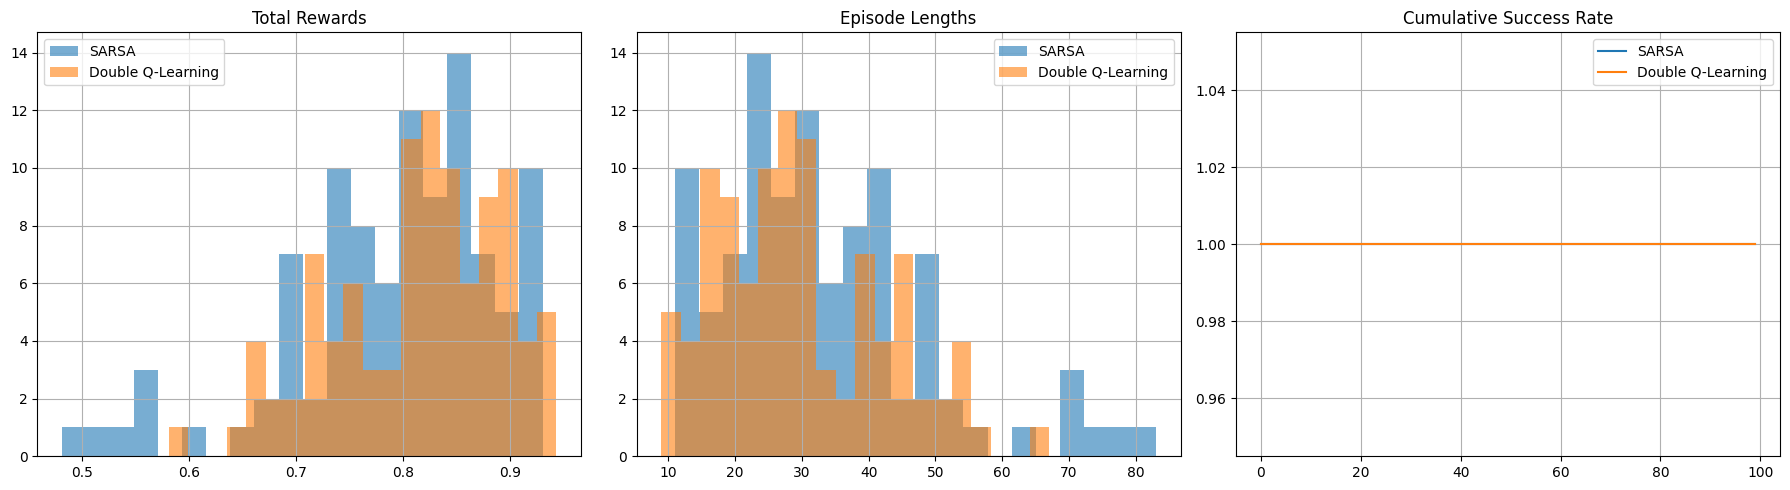

In [72]:
def plot_eval_comparison(sarsa_results, dq_results):
    import matplotlib.pyplot as plt
    import numpy as np

    print(f"SARSA – Success Rate: {np.mean(sarsa_results['successes']):.2f}, "
          f"Avg Reward: {np.mean(sarsa_results['rewards']):.2f}, "
          f"Avg Steps: {np.mean(sarsa_results['steps']):.2f}")
    
    print(f"Double Q-Learning – Success Rate: {np.mean(dq_results['successes']):.2f}, "
          f"Avg Reward: {np.mean(dq_results['rewards']):.2f}, "
          f"Avg Steps: {np.mean(dq_results['steps']):.2f}")

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Histogram of rewards
    axs[0].hist(sarsa_results["rewards"], bins=20, alpha=0.6, label="SARSA")
    axs[0].hist(dq_results["rewards"], bins=20, alpha=0.6, label="Double Q-Learning")
    axs[0].set_title("Total Rewards")
    axs[0].legend()
    axs[0].grid()

    # Histogram of steps
    axs[1].hist(sarsa_results["steps"], bins=20, alpha=0.6, label="SARSA")
    axs[1].hist(dq_results["steps"], bins=20, alpha=0.6, label="Double Q-Learning")
    axs[1].set_title("Episode Lengths")
    axs[1].legend()
    axs[1].grid()

    # Success rate over episodes
    sarsa_sr = np.cumsum(sarsa_results["successes"]) / np.arange(1, len(sarsa_results["successes"]) + 1)
    dq_sr = np.cumsum(dq_results["successes"]) / np.arange(1, len(dq_results["successes"]) + 1)

    axs[2].plot(sarsa_sr, label="SARSA")
    axs[2].plot(dq_sr, label="Double Q-Learning")
    axs[2].set_title("Cumulative Success Rate")
    axs[2].legend()
    axs[2].grid()

    plt.tight_layout()
    plt.show()

plot_eval_comparison(sarsa_results, dq_results)
